<h2 style="text-align:center">Image Classification using Convolutional Neural Network with PyTorch</h2>
<h3 style="text-align:center"> By Charles Chinedu Nworu </h3>
<br>
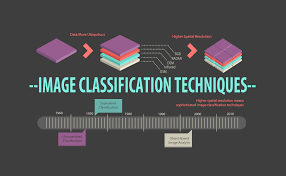

<h3>Problem Statement</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">In this article, I will walk you through on how to do image classification using the traditional CNN architechure. I will be using the pytorch framework. <strong>Note:</strong> By traditional architechure, I mean that no regularisation factor(s) has been applied while biulding our model. This is for some of you who must have come across what regularization does to a model. I won't go into details of what it does for now, but interest is on how to load images with unbalanced labels. Most of the conventional datasets, I have come across in Kaggle and other repositories are arranged in such a way that each image is saved in one folder. In addition, in each folder, those images are of equal sizes. What if images of four classes are saved in one folder?</p>

<h3>Introduction</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Digital pathology aims to apply machine learning to digital pathology images like these to determine if the tissue is normal or cancerous. 
One approach is to segment out the nuclei of cells from these images and classify them into different cell 
types including malignant cell nuclei (i.e. cancerous cells). 
Our overall goal for this data science task is to train a deep neural network which can take a 64x64 image with a cell nuclei at the centre and classify it into one of the following types which are shown in the figures above:
<ol>
    <li>Normal epithelial cells (shown orange). </li>
     <li>Cancer epithelial cells (shown in red). </li>
    <li>Immune Leukocyte cells (shown in green). </li>
    <li>Connective fibroblast cells (shown in blue).</li>
</ol>
The “Deep Learning for MSc Coursework 2021” Kaggle site has a training set of nuclei images (train.zip) and also a csv training file containing their identities (train.csv). It also contains test archive (test.zip) which has similar 64x64 images of unlabelled cell nuclei. (Note that the identity of each image is given by its number 'N.png'. This then corresponds to its identity in the csv files.).
</p>

<h3>Load libraries</h3>

In [24]:
# PyTorch libraries and modules
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid

# for reading data and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline

# for tranforming the labels
from sklearn import preprocessing

# for evaluating the model
from sklearn.metrics import accuracy_score

# for shuffling the data
import random

<h3>Loading dataset</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The dataset contains identities of the images in the training.zip folder. Ensure the the csv file is the same path with the jupyter notebook you're using. </P

In [6]:
data = pd.read_csv('train.csv')
data.head()

,Id,Type
0,1,Connective
1,2,Connective
2,3,Connective
3,4,Connective
4,5,Connective


<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Let's get the number of images for each class. It is obvious that the dataset is highly imbalanced. Unfortunately, this article do not cover how to deal with imbalanced dataset in an image classification problem. But in ubsequent writeups, I will try to solve this problem</p>

In [9]:
data['Type'].value_counts()

Immune        729
Connective    726
Cancer        546
Normal        189
Name: Type, dtype: int64

In [10]:
data['Type'].unique()

array(['Connective', 'Immune', 'Cancer', 'Normal'], dtype=object)

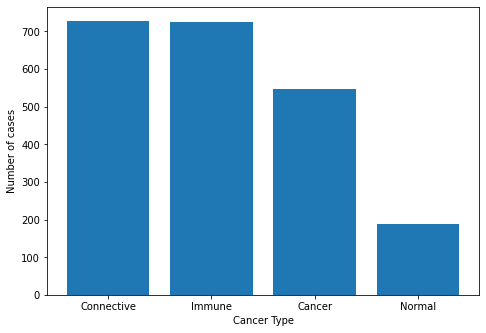

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cancerType =  data['Type'].unique() 
no_of_cases = data['Type'].value_counts()
ax.bar(cancerType, no_of_cases)
ax.set_xlabel("Cancer Type")
ax.set_ylabel("Number of cases")
plt.show()

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The bar plot above shows the graphical distribution of the classes. Clearly, Normal epithelial cells is the lowest. Studies have shown that this distribution can bring some element of bias to our learning algorithm.</p>

<h3>Load Images for the training set</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The pixel values range from 0 to 256, apart from 0 the range is 255. To reduce this we can normalize the values to range from 0 to 1. In this way, the numbers will be small and the computation becomes easier and faster. So dividing all the values by 255 will convert it to range from 0 to 1.</p>

In [12]:
train_img = []
for img_name in tqdm(data['Id']): # tqdm is a library in Python which is used for creating Progress Meters.
    image_path = 'train/train/' + str(img_name) + '.png'
    img = imread(image_path)
    img = img/255
    train_img.append(img)

100%|██████████| 2190/2190 [00:02<00:00, 744.20it/s]


<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">A helper function for displaying images given the corrsponding id. The example below is for id=2185. You can play around with other ids. Ensure you don't pass an id above the length size of the training dataset, that is 2190.</p>

Label:  Immune


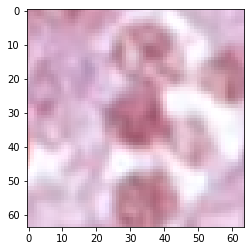

In [17]:
def show_example(img, id):
    print("Label: ", data["Type"][id])
    plt.imshow(img[id])
    
show_example(train_img, 2185)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Next, we convert the images to an array and then reshape it to suit PyTorch format. The numpy array format is (2190, 64, 64, 3) which will be rearranged to (2190, 3, 64, 64). Note: '2190' is the size of the data, '3' is the number of channels (RGB) of the images while '64,64' means height and width of the image.</p>

In [20]:
train_x = np.array(train_img)
train_x = train_x.reshape(2190,3,64,64)
# converting training images into torch format
train_x = torch.Tensor(train_x)
train_x.shape

torch.Size([2190, 3, 64, 64])

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The textual labels are converted into numeric data for efficiency during model training.</p>

In [21]:
from sklearn import preprocessing
train_y = data['Type'].values
print(train_y)
le = preprocessing.LabelEncoder()
train_y = le.fit_transform(train_y)
train_y = torch.as_tensor(train_y)
print(train_y)

['Connective' 'Connective' 'Connective' ... 'Connective' 'Connective'
 'Immune']
tensor([1, 1, 1,  ..., 1, 1, 2])


<h3>Combine the input images and labels</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Let's combine our input images with the corresponding labels/identities. The result for each iteration is a tuple.</p>

In [44]:
dataset = []
inputs = train_x
labels = train_y
for i in range(len(train_x)):
    combined = inputs[i], labels[i]
    dataset.append(combined)

<h3>Split into training and validation sets</h3>

In [45]:
def split_index(n, val_pct=0.2, seed=99):
    # Determine the size of the validation set
    n_val = int(val_pct * n)
    # to ensure reproducibilty
    np.random.seed(seed)
    # Create random permutation of 0 to n-1
    index = np.random.permutation(n)
    # Pick first ratio indices for validation set
    return index[n_val:], index[:n_val]

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">We divided the dataset into two proportions: 80% for training and 20% for validation</p>

In [46]:
# Select 20% for validation
train_indices, val_indices = split_index(len(dataset))

<h3>Random Sampler and DataLoader</h3>
<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The subset random loader is used to shuffle the data for each batch size. This is done to eliminate any form of bias during data loading. The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model's internal parameters are updated. In general, batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. Other values (lower or higher) may be fine for some data sets, but the given range is generally the best to start experimenting with. The dataloader provides a platform for selecting a defined number of batch size. I will be working with 128, but you can experiment with other values and see how it affects the model's performance</p>

In [109]:
from torch.utils.data.sampler import SubsetRandomSampler
BATCH_SIZE = 128
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

In [110]:
# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

In [117]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8,16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        print(images.shape)
        break

torch.Size([128, 3, 64, 64])


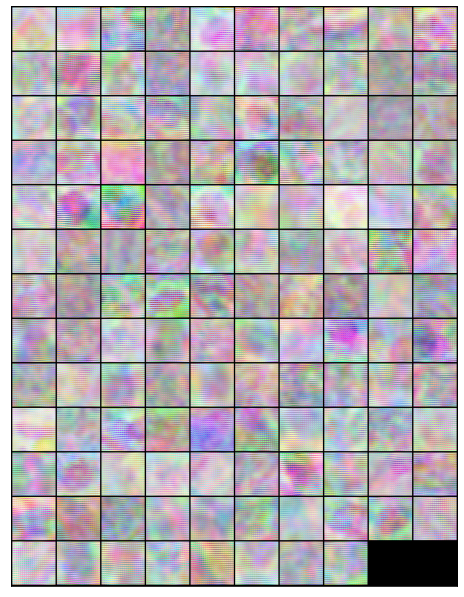

In [118]:
 show_batch(train_loader)

torch.Size([128, 3, 64, 64])


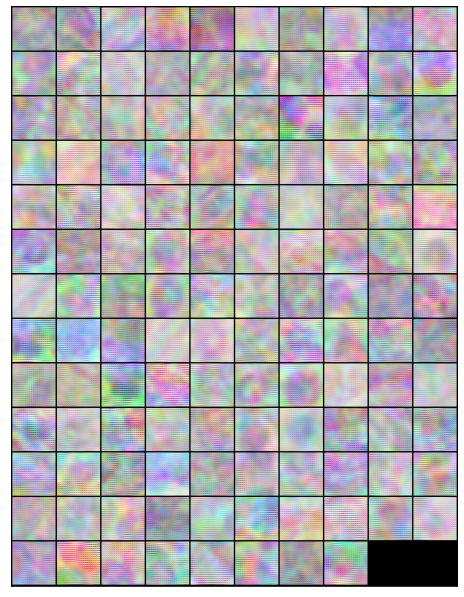

In [119]:
 show_batch(val_loader)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Lets define a help function to ensure that our code uses the GPU</p>

In [50]:
def get_default_device():
    """Select GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cpu')

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Define a model to move data and model to the device</p>

In [51]:
def to_device(data, device):
  """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Device data loader</p>

In [52]:
class DeviceDataLoader():
    def __init__(self, dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [53]:
device = get_default_device()
device

device(type='cpu')

<h2>CNN Architechure</h2>

<img src=https://www.researchgate.net/profile/Aftab-Alam-38/publication/344294512/figure/fig1/AS:936958935191552@1600399826350/A-generic-CNN-Architecture.png alt = "CNN Architechure">

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">For the purpose of this work, we used the six(6) hidden layers and one fully connected layer. These are hyper-parameters which we could vary and monitor their effects. Additionally, the output size in the first layer, in our own case is 32, ia a hyperparameter could be varied as well. The calculation of the output size for other layers can be found in the <a href="https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer">link</a> </p> 

In [120]:
model = nn.Sequential(
    # Defining a 2D convolution layer
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2), # output: bs x 32 x 32 x 32

    # Defining another 2D convolution layer 
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output: bs x 32 x 16 x 16

    # Defining another 2D convolution layer
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),   # output: bs x 32 x 8 x 8

    # Defining another 2D convolution layer
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output: bs x 32 x 4 x 4

    # Defining another 2D convolution layer
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2,2),     # output: bs x 32 x 2 x 2

    # Defining another 2D convolution layer
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),   # output: bs x 32 x 1 x 1

    nn.Flatten(),
    nn.Linear(32, 4)
)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">
Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset. The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.</p>

In [121]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

to_device(model, device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): Conv2d(32, 32, kernel_size=(3, 3), stride=(

<h3>Training the model</h3>

In [56]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    # Generate predictions
    preds = model(xb)
    # Generate loss
    loss = loss_func(preds, yb)
    if opt is not None:
        # Generate gradients
        loss.backward()
        # Update parameters
        opt.step()
        # Reset gradients 
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        # Compute the metric
        metric_result = metric(preds, yb)
    return loss.item(), len(xb), metric_result

<h3>Evaluate function calculates the overall loss</h3>

In [57]:
def evaluate(model, loss_fn, valid_dl=val_dl, metric=None):
    with torch.no_grad():
        # Pass each batch thru the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        # Seperate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        # Total size of the dataset
        total = np.sum(nums)
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        if metric is not None:
          # avg. of metric across batches
          avg_metric = np.sum(np.multiply(metrics, nums))/total
        return avg_loss, total, avg_metric

<h3>Model Fit</h3>

In [58]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_fn =None, lr=None, metric=None):
    train_losses, val_losses, val_metrics = [], [], []
  # Instantiate the optimizer
    if opt_fn is None: 
        opt_fn = torch.optim.SGD
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Training
        model.train()
        for xb, yb in train_dl:
            train_loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
        # Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        # Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        # Print progress
        if metric is None:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}, val_{}:{:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            
    return train_losses,val_losses,val_metrics         

<h3>Helper function for calculating the accuracy of our model</h3>

In [122]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Before we start training our model, it is important to note that there are some factors that can affect its performance. This is what we call the hyper-parameters. In this case, we have the number of epochs, optimization function and the learning rate. You can try other values for the number of epochs and the learning rate. For the learning rate, it is important not to choose a large learning rate. Though our model might converge quickly but it will lead to an undesirable divergent behaviour in our loss function. With respect to the optimization function, I chose the 'Adam' optimization function but you can try the 'SGD'.</p>

In [123]:
num_epochs = 100
opt_fn = torch.optim.Adam
lr = 0.0005

history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, opt_fn, lr, accuracy)

Epoch [1/100], train_loss: 1.5064, val_loss: 1.3707, val_accuracy:0.3425
Epoch [2/100], train_loss: 1.4203, val_loss: 1.3703, val_accuracy:0.3425
Epoch [3/100], train_loss: 1.4207, val_loss: 1.3700, val_accuracy:0.3425
Epoch [4/100], train_loss: 1.3662, val_loss: 1.3690, val_accuracy:0.3425
Epoch [5/100], train_loss: 1.3544, val_loss: 1.3683, val_accuracy:0.3425
Epoch [6/100], train_loss: 1.3705, val_loss: 1.3644, val_accuracy:0.3516
Epoch [7/100], train_loss: 1.3259, val_loss: 1.3564, val_accuracy:0.3470
Epoch [8/100], train_loss: 1.3289, val_loss: 1.3496, val_accuracy:0.3493
Epoch [9/100], train_loss: 1.2991, val_loss: 1.3437, val_accuracy:0.3425
Epoch [10/100], train_loss: 1.3480, val_loss: 1.3385, val_accuracy:0.3333
Epoch [11/100], train_loss: 1.3581, val_loss: 1.3337, val_accuracy:0.3470
Epoch [12/100], train_loss: 1.3262, val_loss: 1.3294, val_accuracy:0.3562
Epoch [13/100], train_loss: 1.3163, val_loss: 1.3257, val_accuracy:0.3904
Epoch [14/100], train_loss: 1.3358, val_loss: 1

In [124]:
train_losses,val_losses,val_metrics = history

In [125]:
# Examine the performance of the validation set 
val_loss,_,val_acc = evaluate(model, F.cross_entropy, val_dl, metric=accuracy)
print('Loss:{:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss:1.1794, Accuracy: 0.5228


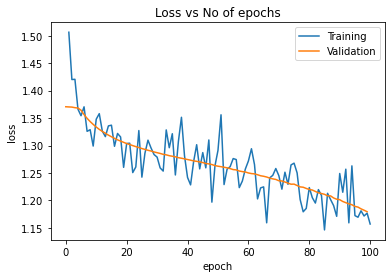

In [136]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No of epochs')

plot_losses([None]+ train_losses, val_losses)

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The id for the test images ranges from 10001 to 10400. We decided to create a list containing those values.</p>

In [68]:
test_id = list(range(10001, 10401))

In [69]:
# Test Images
test_img = []
for img_name in tqdm(test_id):
    image_path = 'test/test/' + str(img_name) + '.png'
    img = imread(image_path)
    img = img/255
    test_img.append(img)

100%|██████████| 400/400 [00:00<00:00, 785.74it/s]


In [70]:
test_set = np.array(test_img)
test_set = test_set.reshape(400,3,64,64)
# converting training images into torch format
test_set = torch.Tensor(test_set)
test_set.shape

torch.Size([400, 3, 64, 64])

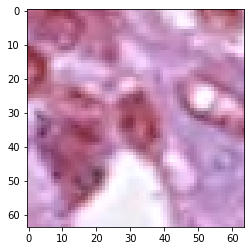

In [71]:
def test_show_example(img, id):
    plt.imshow(img[id])
    
test_show_example(test_img, 200)

In [127]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_set.cpu())
    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)

In [128]:
print(predictions)

[1 1 2 2 1 1 1 1 1 1 2 1 2 2 2 1 2 2 2 2 1 2 1 2 2 2 2 2 1 1 1 1 1 1 2 1 1
 2 2 1 1 1 1 2 2 2 1 1 2 2 2 1 2 1 1 2 1 1 2 1 1 2 1 2 1 1 2 2 2 1 2 2 1 1
 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2
 1 2 1 2 1 1 1 1 2 1 2 1 1 2 1 1 1 1 1 1 1 1 2 1 2 2 2 1 2 1 2 2 2 2 2 1 1
 1 1 2 1 2 2 2 1 1 2 1 2 1 2 1 2 2 2 1 0 2 2 0 1 1 1 0 1 1 2 0 2 1 1 2 0 0
 2 0 1 0 2 2 0 0 2 1 0 1 0 0 0 2 1 2 2 0 0 0 0 2 2 0 1 1 2 2 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 2 1
 2 1 0 0 1 0 2 0 1 1 1 0 0 1 2 1 0 1 1 1 1 2 1 1 1 1 1 0 0 1 0 2 1 1 1 2 2
 2 1 1 1 2 0 2 2 2 2 1 2 2 2 0 2 1 2 2 2 1 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 2 2 2 1 0 1 1 0 1 2 0 1 2 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 1 2 1 1 2 1 1 2 0 1 2 1 1]


<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">Using the inverse_tranform function, we change our predicted values to its original form.</p>

In [129]:
 types = le.inverse_transform(predictions)

In [130]:
data = {
  "id": test_id,
  "test_predictions": types
}
df = pd.DataFrame(data)

In [131]:
df

,id,test_predictions
0,10001,Connective
1,10002,Connective
2,10003,Immune
3,10004,Immune
4,10005,Connective
...,...,...
395,10396,Cancer
396,10397,Connective
397,10398,Immune
398,10399,Connective


In [132]:
 df['test_predictions'].unique() 

array(['Connective', 'Immune', 'Cancer'], dtype=object)

In [133]:
 df['test_predictions'].value_counts()

Connective    222
Immune        121
Cancer         57
Name: test_predictions, dtype: int64

<p style="font-family:'Times New Roman';font-size: 16px;text-align: justify">The distribution above shows the effect of having an imbalanced dataset for training. The Normal epithelial cells have been subdued by other cells during training. One way of solving this problem is by oversampling the minority class thereby increasing performance. We can also tune the parameters of the model which I have earlier outlined. In my next article, I will introduce the concept of regularization in CNN and its implememntation in PyTorch. Thank you.</p>